In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

time_epoch = 60
epochs_per_batch = 40

# hard coded nrows
df_all = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=500000)

df_all.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df = df_all[df_all['time'] <= epochs_per_batch * time_epoch]

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.head()

c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1,0,C1065,389,C3799,N10451,6,10,5323
1,0,C1423,N1136,C1707,N1,6,5,847
1,0,C1423,N1142,C1707,N1,6,5,847
1,0,C14909,N8191,C5720,2049,6,1,52
1,0,C14909,N8192,C5720,2049,6,1,52


In [2]:
# get all the host in the buckets we are interested in 

hosts = np.array(list(set(df_all[df_all['time'] <= epochs_per_batch * time_epoch]['source computer'].values))) 

In [3]:
from helper import group_scale_data, group_scale_data_batch

groupped_data, hosts, parameters = group_scale_data(df, size_of_bin_seconds=60,
                                                    addZeros=False, doScale=True, scaler='log', verbose=1, hosts=hosts)

A total of 40 time epochs have been encountered
Scaling...


In [4]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus

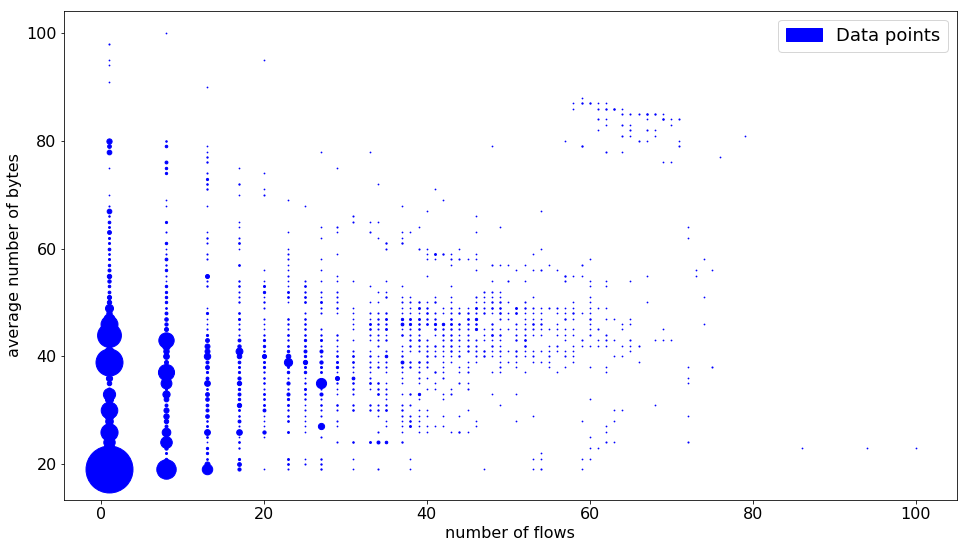

In [5]:
plot_points(groupped_data.values[:, :2])

In [6]:
import scipy.stats.distributions
from math import log
import sys
import numpy as np


def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    if return_value == 0:
        return sys.float_info.epsilon
    return return_value


class GreedyEM:
    def __init__(self, x, stochastic=True, stochastic_n_samples=10000, random_seed=42, maximum_mixtures=20,
                 convergence_error=0.000001, verbose=0):
        """
        :param stochastic: When stochastic is True for faster calculation only keep a smaller subset 
                            of the data of size stochastic_n_samples
        """
        assert len(x) >= 0

        if stochastic and stochastic_n_samples < len(x):
            idx = np.random.randint(len(x), size=stochastic_n_samples)
            self.x = np.vstack(x[idx,:])
        else:
            self.x = np.vstack(x)

        # calculate distances from all points to all points
        self.distances = np.zeros(shape=(len(self.x), len(self.x)))
        for i, x_i in enumerate(self.x):
            if verbose > 0 and i % 100 == 0:
                print('Done with', i)
            for j, x_j in enumerate(self.x):
                self.distances[i][j] = poisson(x_j, x_i)

        self.m = len(x[0])
        self.lambdas = np.vstack([np.mean(self.x, axis=0, dtype=np.int64)])
        self.gammas = np.array([1])

        # initialize the probabilities for each individual data points
        self.probabilities = np.zeros(len(self.x))
        self._calculate_probabilities()

        self.maximum_mixtures = maximum_mixtures
        self.convergence_error = convergence_error
        
        self.lambdas_history = [self.lambdas]
        self.gammas_history = [self.gammas]

    def _calculate_probabilities(self):
        for i, x_i in enumerate(self.x):
            self.probabilities[i] = np.sum(self.gammas * np.array([poisson(x_i, lambda_i) for lambda_i in self.lambdas]))

    def _calculate_likelihood(self):
        # naive implementation for likelihood calculation
        new_likelihood = 0
        for x in self.x:
            total_x = np.sum(self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas]))
            new_likelihood = new_likelihood + log(total_x)
        return new_likelihood

    def _calculate_deltas(self, i):
        deltas = np.zeros(len(self.x))
        for j in range(len(self.x)):
            deltas[j] = (self.probabilities[j] - self.distances[i][j]) / (self.probabilities[j] + self.distances[i][j])
        return deltas

    def _calculate_new_likelihood(self, i):
        deltas = self._calculate_deltas(i)

        new_likelihood = 0
        for j in range(len(self.x)):
            new_likelihood += log((self.probabilities[j] + self.distances[i][j]) / 2)

        new_likelihood += 0.5 * pow(sum(deltas), 2) / sum(deltas ** 2)
        return new_likelihood

    def _calculate_participation(self):
        f = np.zeros(shape=(len(self.x), len(self.lambdas)))
        for i, x_i in enumerate(self.x):
            participation = self.gammas * np.array([poisson(x_i, lambda_i) for lambda_i in self.lambdas])
            total_x = np.sum(participation)
            f[i] = participation / total_x
        return f

    def _run_em(self):
        previous_likelihood = self._calculate_likelihood()
        while True:
            f = self._calculate_participation()
            temp_sum = f.sum(axis=0)
            self.gammas = temp_sum / len(self.x)

            temp = np.zeros(shape=(len(self.lambdas), len(self.lambdas[0])))
            for i, x_i in enumerate(self.x):
                temp = temp + np.vstack([x_i * f_i for f_i in f[i]])
            self.lambdas = np.vstack([temp[i] / temp_i for i, temp_i in enumerate(temp_sum)])

            new_likelihood = self._calculate_likelihood()
            convergence = new_likelihood / previous_likelihood - 1
            if - self.convergence_error < convergence < self.convergence_error:
                break
                
            previous_likelihood = new_likelihood

    def init_centers(self, verbose=0):
        previous_likelihood = self._calculate_likelihood()
        while len(self.lambdas) < self.maximum_mixtures:
            # choose the best x_i for the next center
            new_likelihoods = np.zeros(len(self.x))
            for i in range(len(self.x)):
                """
                Avoid choosing the same value twice TODO
                """
                if list(self.x[i]) in self.lambdas.tolist():
                    new_likelihoods[i] = - sys.float_info.max
                else:
                    new_likelihoods[i] = self._calculate_new_likelihood(i)

            new_i = np.argmax(new_likelihoods)
            new_center = self.x[new_i]
            deltas = self._calculate_deltas(new_i)

            a = 0.5 - 0.5 * sum(deltas) / sum(deltas ** 2)
            if a < 0 or a > 1:
                if len(self.lambdas) == 1:
                    a = 0.5
                else:
                    a = 2 / (len(self.lambdas) + 1)
            
            print('=============================================================================')
            print('New center', self.x[new_i])

            if list(self.x[new_i]) in self.lambdas.tolist():
                """
                This point already exists as a center.
                This is a special case and should not happen under normal circumstances.
                """
                print('This should never happen!!!!!!!!!!!!!!!!!!!!!!!!!!')
            else:
                self.gammas = np.append(self.gammas * (1 - a), a)
                self.lambdas = np.vstack([self.lambdas, self.x[new_i]])

            self._run_em()

            self._calculate_probabilities()

            new_likelihood = self._calculate_likelihood()

            print('-------')
            print(self.gammas)
            print(self.lambdas)
            self.lambdas_history.append(self.lambdas)
            self.gammas_history.append(self.gammas)
            
            if previous_likelihood > new_likelihood:
                print('WORSE LIKELIHOOD')
                print('Previous', previous_likelihood)
                print('New', new_likelihood)
                # break

            previous_likelihood = new_likelihood

In [11]:
greedy = GreedyEM(groupped_data.values[:, :2], stochastic_n_samples=300, maximum_mixtures=10, verbose=1)

Done with 0
Done with 100
Done with 200


In [12]:
greedy.init_centers()

New center [37 40]
-------
[ 0.80880393  0.19119607]
[[2.839948875864017 31.4880780607532]
 [28.015071353639296 43.510232158602754]]
New center [8 41]
-------
[ 0.6092731  0.1259757  0.2647512]
[[1.0009618334884824 30.874250395120082]
 [35.21895910606116 42.821950573754926]
 [9.84600325774426 36.189793338616575]]
New center [1 47]
-------
[ 0.34523177  0.12930014  0.24635533  0.27911277]
[[1.0027204755085328 21.474859956265494]
 [34.67729951328463 43.499227621985725]
 [10.009135568087203 33.40345327161654]
 [1.2811273674783508 44.853871306273895]]
New center [8 63]
-------
[ 0.33306003  0.12529041  0.23125286  0.27353072  0.03686598]
[[1.0015112545828446 21.14852704376497]
 [35.29053993829901 42.88815993776255]
 [10.00438547833926 31.76773585014606]
 [1.0011408421706782 42.165798222728164]
 [8.43103413471617 67.52679651871185]]
New center [48 52]
-------
[ 0.33284172  0.10213873  0.22661885  0.27369896  0.03663141  0.02807033]
[[1.0014567720139422 21.142785896220005]
 [29.7879350892704

In [ ]:
plot_points(groupped_data.values[:, :2], em=greedy)

In [14]:
greedy.gammas = np.array([ 0.33281511,  0.10242297,  0.14950694,  0.27352513,  0.0270293,   0.02850404,
  0.0861965 ])
greedy.lambdas = np.vstack([[1.0003828154730423, 21.144455176326073],
 [29.650053204170156, 38.080456752194536],
 [9.339029255682357, 38.80733880981068],
 [1.0004068318634534, 42.147441995267215],
 [7.613362314242781, 73.0052050795464],
 [52.281906631447974, 58.3742308450728],
 [10.64577689736969, 21.829502028189935]])

In [23]:
def gett(x):
    index = [tuple(x) for x in greedy.x].index(x)
    return index

In [25]:
greedy._calculate_new_likelihood(gett((1,19)))

-1933.5115632769105

In [28]:
greedy._calculate_new_likelihood(gett((61,86)))

-1954.7735090420053

In [30]:
deltas = greedy._calculate_deltas(gett((61,86)))
0.5 - 0.5 * sum(deltas) / (sum(deltas ** 2))

0.0065216919953319796

In [13]:
set([tuple(x) for x in greedy.x])

{(1, 19),
 (1, 20),
 (1, 21),
 (1, 23),
 (1, 24),
 (1, 26),
 (1, 27),
 (1, 28),
 (1, 29),
 (1, 30),
 (1, 31),
 (1, 33),
 (1, 36),
 (1, 37),
 (1, 38),
 (1, 39),
 (1, 40),
 (1, 41),
 (1, 43),
 (1, 44),
 (1, 45),
 (1, 46),
 (1, 47),
 (1, 49),
 (1, 51),
 (1, 52),
 (1, 53),
 (1, 55),
 (1, 78),
 (1, 80),
 (8, 19),
 (8, 20),
 (8, 24),
 (8, 26),
 (8, 28),
 (8, 32),
 (8, 33),
 (8, 35),
 (8, 37),
 (8, 40),
 (8, 41),
 (8, 42),
 (8, 43),
 (8, 45),
 (8, 50),
 (8, 52),
 (8, 63),
 (8, 75),
 (8, 76),
 (8, 80),
 (13, 19),
 (13, 20),
 (13, 31),
 (13, 32),
 (13, 33),
 (13, 36),
 (13, 41),
 (13, 62),
 (13, 73),
 (17, 26),
 (17, 30),
 (17, 31),
 (17, 36),
 (17, 41),
 (17, 57),
 (20, 53),
 (23, 28),
 (23, 39),
 (23, 59),
 (25, 27),
 (25, 37),
 (25, 47),
 (27, 27),
 (27, 30),
 (27, 35),
 (27, 38),
 (27, 43),
 (31, 33),
 (31, 36),
 (31, 54),
 (33, 31),
 (37, 40),
 (37, 47),
 (38, 31),
 (38, 33),
 (38, 46),
 (38, 51),
 (40, 41),
 (40, 48),
 (41, 59),
 (44, 29),
 (46, 47),
 (48, 52),
 (49, 50),
 (57, 47),
 (58,

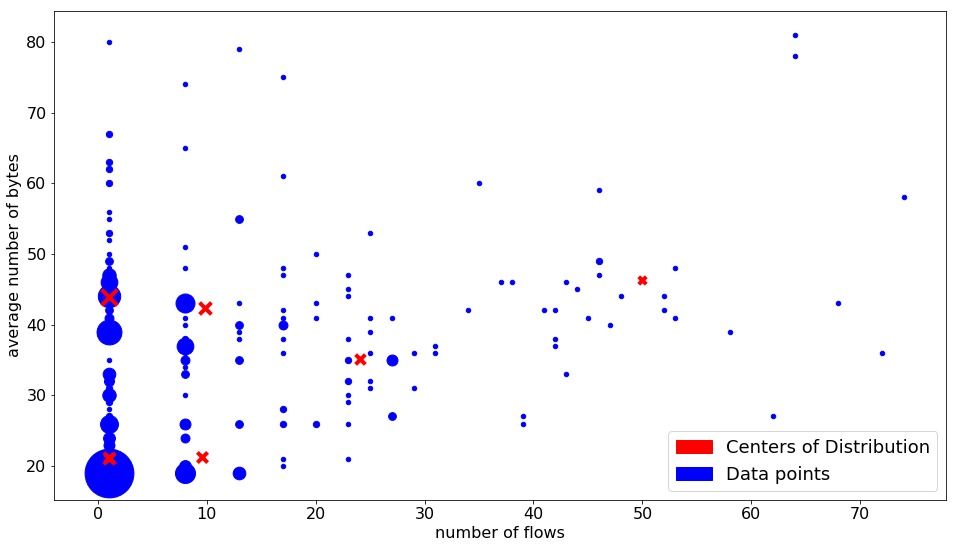

In [10]:
plot_points(greedy.x, em=greedy)

In [11]:
# TEST IN GENERATED DATASET 

# create database
import numpy as np
size = 500

s1 = np.random.poisson(90, size)
s2 = np.random.poisson(80, size)

data = np.column_stack((s1,s2,np.array(['c']*size, dtype=object)))

s1 = np.random.poisson(5, size)
s2 = np.random.poisson(5, size)

data = np.append(data, np.column_stack((s1,s2,np.array(['c']*size, dtype=object))), axis=0)

s1 = np.random.poisson(60, size)
s2 = np.random.poisson(5, size)

data = np.append(data, np.column_stack((s1,s2,np.array(['c']*size, dtype=object))), axis=0)

s1 = np.random.poisson(10, size)
s2 = np.random.poisson(75, size)

data = np.append(data, np.column_stack((s1,s2,np.array(['c']*size, dtype=object))), axis=0)

np.random.shuffle(data)

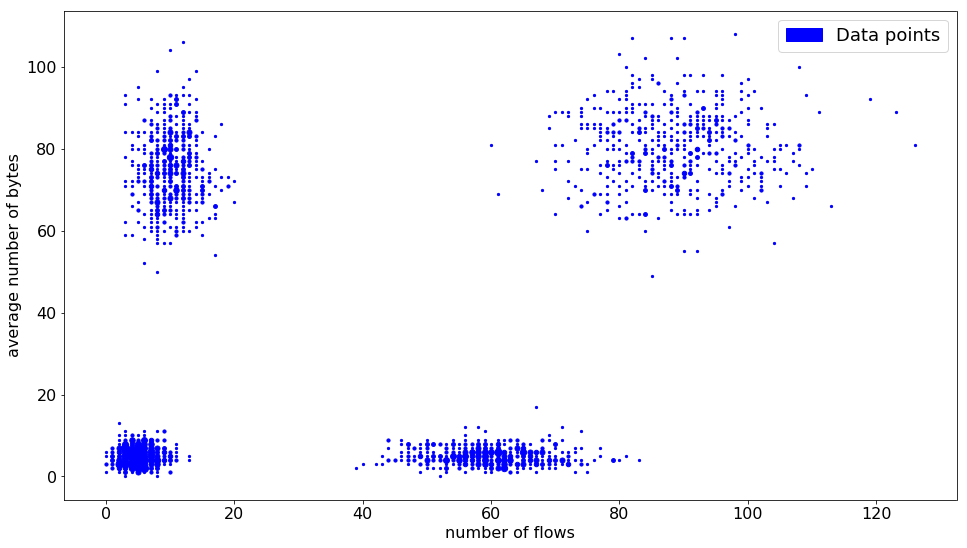

In [12]:
from plots import plot_points

plot_points(data[:,:2])

In [13]:
greedy = GreedyEM(data[:, :2], stochastic_n_samples=500, maximum_mixtures=4, verbose=1)

Done with 0
Done with 100
Done with 200
Done with 300
Done with 400


In [15]:
greedy.init_centers()

New center [40 3]
-------
[ 0.494  0.506]
[[48.5789473739576 78.08906880755029]
 [33.44268773718894 4.96047430476767]]
New center [10 75]
-------
[ 0.244  0.506  0.25 ]
[[87.85245901541815 80.99180327569557]
 [33.44268774628116 4.960474308028501]
 [10.24799999999886 75.2559999999893]]
New center [5 5]
-------
[ 0.244  0.258  0.25   0.248]
[[87.85245901639344 80.9918032786885]
 [60.61240310074939 4.852713178294653]
 [10.248 75.256]
 [5.177419354834322 5.072580645161326]]


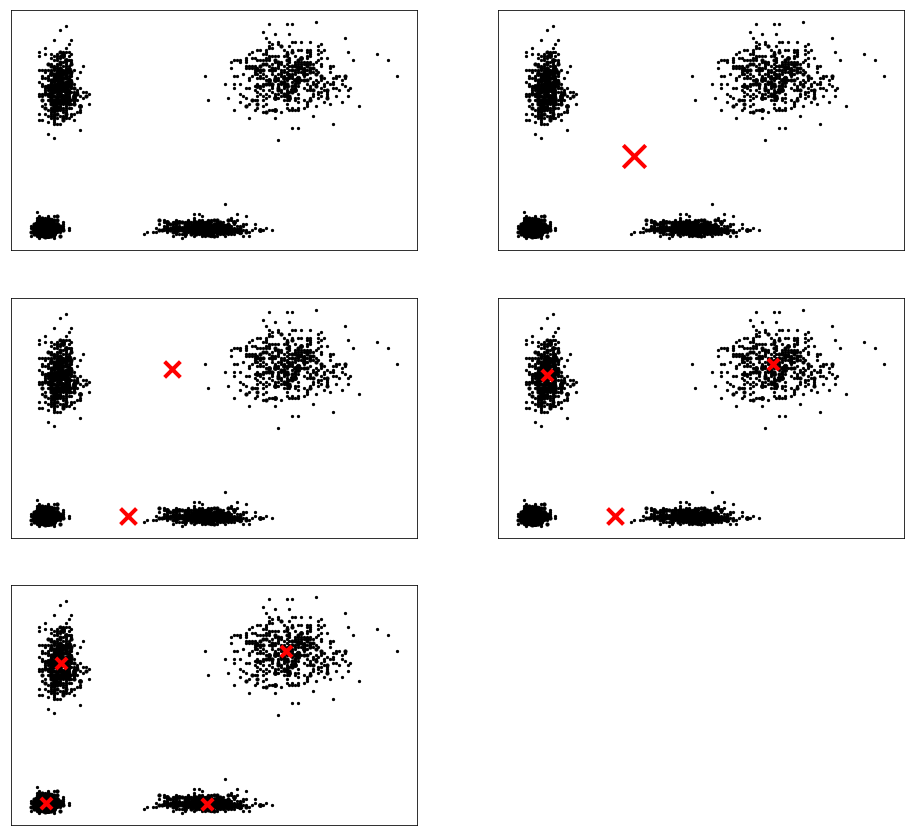

In [16]:
from pylab import rcParams
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.patches as mpatches

colors = ['blue', 'red', 'green', 'yellow']
styles = ['-','--',':','-.']
rcParams['font.size'] = 5
rcParams['figure.figsize'] = 16, 15


data_hashable = [tuple(x) for x in data[:, :2]]
total_points = len(data_hashable)

values = np.vstack([list(x) for x in list(Counter(data_hashable).keys())])
counts = np.array(list(Counter(data_hashable).values()))


def plot_points(em=None):
    for i in range(len(values)):
        plt.scatter(values[i][0], values[i][1], s=counts[i]*10000/total_points, color='black')
        
    if em:
        for i, lambda_i in enumerate(em.lambdas):
            plt.scatter(lambda_i[0], lambda_i[1], s=em.gammas[i]*500, linewidth=4, color='red', marker='x')
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([]) 
          
        
        
        
plt.subplot(3,2,1)
plot_points()
i = 2
for lambdas_i, gammas_i in zip(greedy.lambdas_history, greedy.gammas_history):
    # temp object
    plt.subplot(3,2,i)
    greedy_step = lambda: None
    greedy_step.lambdas = lambdas_i
    greedy_step.gammas = gammas_i
    plot_points(em=greedy_step)
    
    i += 1
    

plt.show()